Import Libraries

In [3]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax import config
from flax import linen as nn
!pip install evojax
from evojax.util import get_params_format_fn

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
jax.config.update("jax_enable_x64", True)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
input_dir = "/content/drive/My Drive/DNN + Helmholtz/"

Mounted at /content/drive


Problem: 2D Helmholtz Equation

        (u_xx + u_yy) + k**2 * u = g

In [5]:
# Function to generate analytical solution
@jit
def eval_u(x, y, a1, a2):
    u = jnp.sin(a1*jnp.pi*x) * jnp.sin(a2*jnp.pi*y)
    return u

# obtain g
@jit
def eval_g(x, y, a1, a2):
    g = (k**2 - (a1*jnp.pi)**2 - (a2*jnp.pi)**2) * jnp.sin(a1*jnp.pi*x) * jnp.sin(a2*jnp.pi*y)
    return g

x_l, x_u = -1, 1
y_l, y_u = -1, 1

# PDE parameters
k = 1
a1, a2 = jnp.meshgrid(jnp.linspace(0, 6, 11)[1:], jnp.linspace(0, 6, 11)[1:])
a1, a2 = a1.reshape(-1, 1), a2.reshape(-1, 1)
task_params = jnp.hstack([a1, a2])
n_task = len(task_params)
print (n_task)
# a1 ∈ (0, 6] and a2 ∈ (0, 6]

100


In [6]:
# sample (64x64)
xs = jnp.linspace(-1, 1, 64)
ys = jnp.linspace(-1, 1, 64)
x, y = jnp.meshgrid(xs, ys)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
inputs = jnp.hstack([x, y])

#### Noiseless source function: analytical

k = 1.0, a1 = 1.2, a2 = 5.4


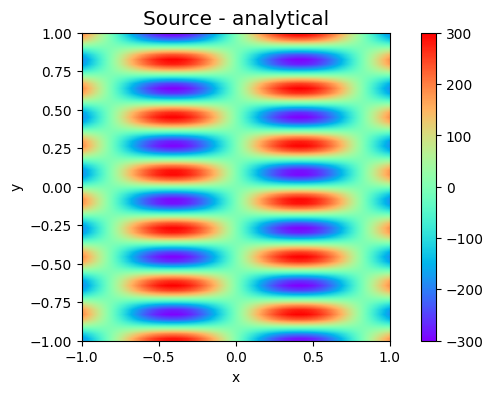

In [7]:
## example (noiseless source function: eval_g)
task = 81

#ground truth: a1 = 1.2, a2 = 5.4
a1, a2 = task_params[task]
g = eval_g(x, y, a1, a2)
print ('k = %.1f, a1 = %.1f, a2 = %.1f'%(k, a1, a2))

# plot
fig = plt.figure(figsize=(8, 4))
ext = [x_l, x_u, y_l, y_u]     # plot boundary
u_plot = g.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y');
plt.title('Source - analytical', fontsize='x-large');

#### Noisy data (inverse inference DNN)

In [8]:
class DNN(nn.Module):
    """DNN"""
    def setup(self):
        self.layers = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       jnp.sin]
        self.last_layer = nn.Dense(1, kernel_init = jax.nn.initializers.he_uniform(), use_bias=False)

    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        x, y = inputs[:,0:1], inputs[:,1:2]
        def get_u(x, y):
            f = jnp.hstack([x, y])
            for i, lyr in enumerate(self.layers):
                f = lyr(f)
                if (i == 0):
                    f = 4 *jnp.pi *f
            u = self.last_layer(f)
            return u

        u = get_u(x, y)

        outputs = u
        return outputs

In [9]:
# choose seed
seed = 8
key, rng = random.split(random.PRNGKey(seed))

# dummy input
a = random.normal(key, [1,2])

# initialization call
n_nodes = 1024
model_inv = DNN()
params_inv = model_inv.init(key, a)
num_params_inv, format_params_fn_inv = get_params_format_fn(params_inv)

# load weigths
params_inv = jnp.load(input_dir + 'InverseDNN_weights.npy')

In [10]:
# noisy source function
g_inv = model_inv.apply(format_params_fn_inv(params_inv), inputs) #use this data for symbolic regression?
#inputs from -1 to 1 (print inputs)

mse = jnp.mean(jnp.square(g_inv - g))
rl2 = jnp.linalg.norm(g_inv - g) / jnp.linalg.norm(g)
print ('Inference source mse = %.3f,  rl2 = %.3f'%(mse, rl2))

Inference source mse = 14.433,  rl2 = 0.027


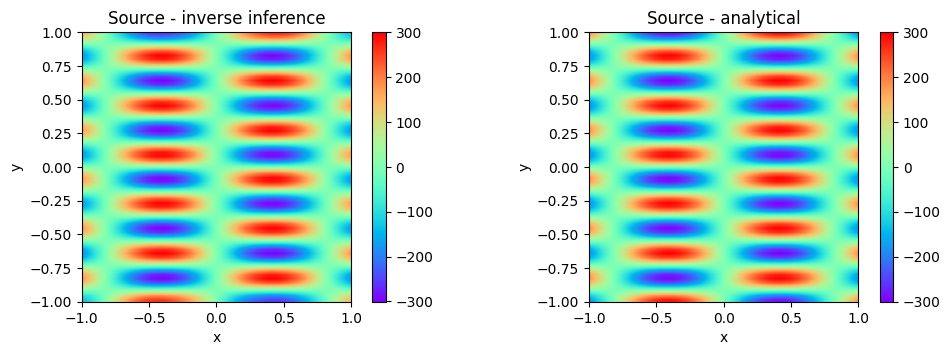

In [11]:
# plot
fig = plt.figure(figsize=(12, 3.5))
ax1 = fig.add_subplot(1,2,1)
u_plot = g_inv.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - inverse inference', fontsize='large');
ax1 = fig.add_subplot(1,2,2)
u_plot = g.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - analytical', fontsize='large');

In [12]:
#Verify working directory
input_path = '/content/drive/My Drive/DNN + Helmholtz/'
os.chdir(input_path)
!pwd

/content/drive/My Drive/DNN + Helmholtz


In [13]:
#check how inputs (x, y) look like
inputs

Array([[-1.        , -1.        ],
       [-0.96825397, -1.        ],
       [-0.93650794, -1.        ],
       ...,
       [ 0.93650794,  1.        ],
       [ 0.96825397,  1.        ],
       [ 1.        ,  1.        ]], dtype=float64)

In [14]:
#Create inv data
data = jnp.hstack([inputs, g_inv]) 
data.shape

(4096, 3)

In [15]:
data_analytical = jnp.hstack([inputs, g])
data.shape

(4096, 3)

In [16]:
# Saving data as a .txt file in working directory for use by symbolic regression function
np.save(input_path + 'helmholtz_data.npy', data)
np.savetxt(input_path + 'helmholtz_data.txt',data,delimiter=' ')

# Printing out generated data with Pandas and plotting it with matplotlib
df=pd.read_csv(input_path + 'helmholtz_data.txt',sep=" ",header=None)
data = df.to_numpy()
print(data.shape) #can also load txt file this way - going to just use generated file from before

(4096, 3)


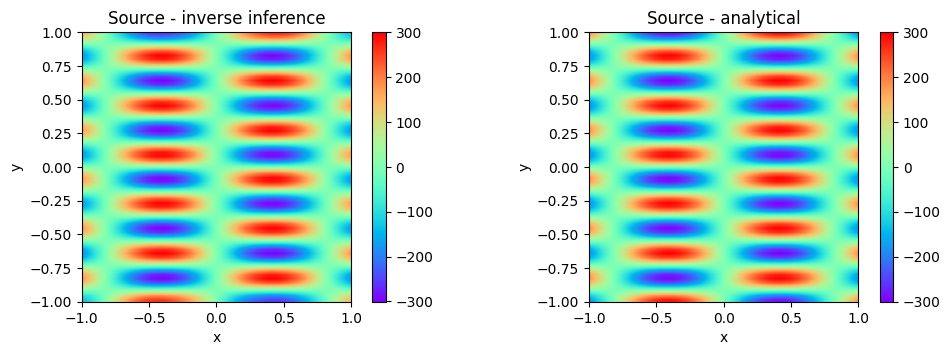

In [17]:
#verify with a plot

fig = plt.figure(figsize=(12, 3.5))
ax1 = fig.add_subplot(1,2,1)
u_plot = data[:,2:3].reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - inverse inference', fontsize='large');
ax1 = fig.add_subplot(1,2,2)
u_plot = g.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - analytical', fontsize='large');

#PySR

In [18]:
# Julia installation
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

In [19]:
# Installing PySR (and relevant packages)
!pip install pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 4.0 MB/s eta 0:00:00


In [20]:
from pysr import pysr, best, PySRRegressor

[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliapkg/juliapkg.json
[juliapkg] Locating Julia ~1.6.7, ~1.7, ~1.8, ~1.9, =1.10.0, ~1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.10.4 to /root/.julia/environments/pyjuliapkg/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to
[juliapkg]   have Julia installed in multiple locations. It is recommended to
[juliapkg]   install JuliaUp (https://github.com/JuliaLang/juliaup) or Julia
[juliapkg]   (https://julialang.org/downloads) yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.4-linux-x86_64.tar.gz
             download complete
[jul

In [21]:
g_inv = g_inv.reshape(-1)
g_inv.shape

(4096,)

In [22]:
#Generating data sets compatible with PySR wagwarn bot dat dign

# np.random.seed(2)
# x_values = np.random.randn(10000, 2)


np.save('x_values_pysr_helmholtz.npy',inputs)
np.savetxt('x_values_pysr_helmholtz.txt',inputs,delimiter=' ')

np.save('y_values_pysr_helmholtz.npy',g_inv)
np.savetxt('y_values_pysr_helmholtz.txt',g_inv,delimiter=' ')

# Converting data into a .txt format compatible with matplotlib (for plotting step)
with open('xy_data_pysr_helmholtz.txt', 'w') as f:
  for r in range(4096):
    f.write(f'{inputs[:, 0][r]} {inputs[:, 1][r]} {g_inv[r]}\n')

<ipython-input-23-c58fba9130b2>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


             0    1           2
0    -1.000000 -1.0 -130.331030
1    -0.968254 -1.0 -113.727729
2    -0.936508 -1.0  -92.210806
3    -0.904762 -1.0  -65.548635
4    -0.873016 -1.0  -34.524182
...        ...  ...         ...
4091  0.873016  1.0  -36.211269
4092  0.904762  1.0  -65.686686
4093  0.936508  1.0  -91.117365
4094  0.968254  1.0 -112.378302
4095  1.000000  1.0 -130.251408

[4096 rows x 3 columns]


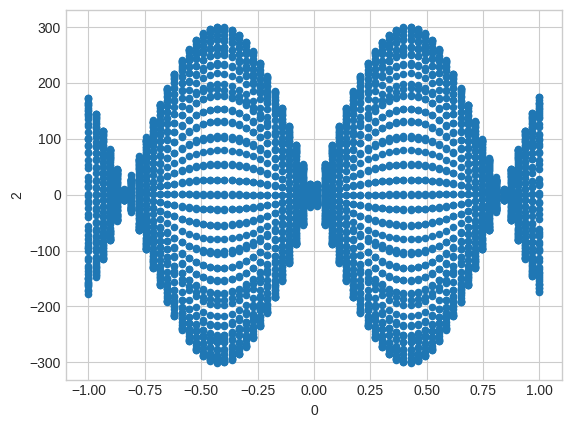

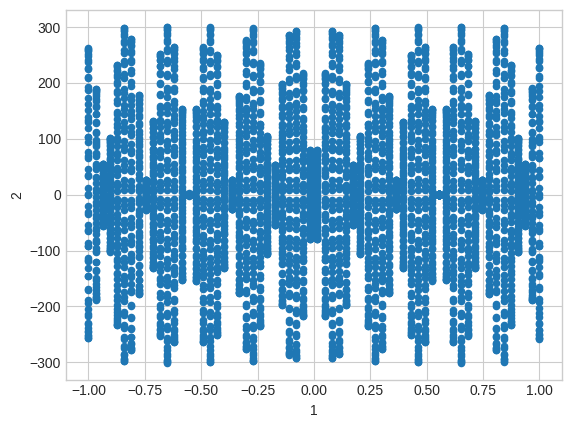

In [23]:
# Printing perfect data with Pandas and plotting it with matplotlib
plt.style.use('seaborn-whitegrid')
df=pd.read_csv(input_path + 'xy_data_pysr_helmholtz.txt',sep=" ",header=None)
df.plot.scatter(x=0, y=2)
df.plot.scatter(x=1, y=2)
print(df)

In [24]:
#more plotting to verify data
data = df.to_numpy()
print(data.shape) #can also load txt file this way - going to just use generated file from before

(4096, 3)


(4096, 1)


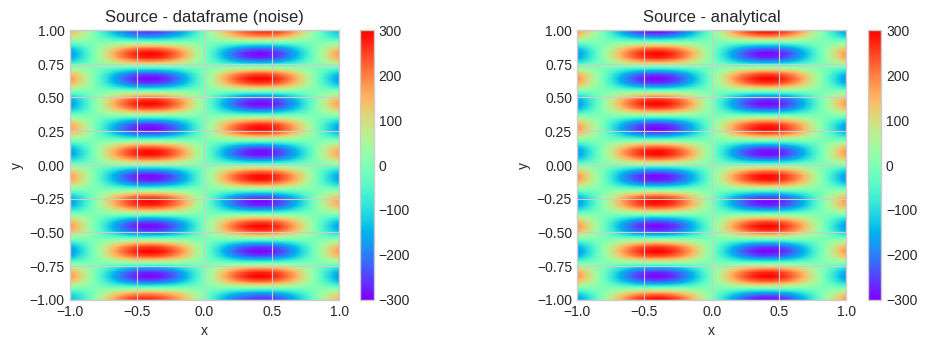

In [25]:
#verify data with a plot 

fig = plt.figure(figsize=(12, 3.5))
ax1 = fig.add_subplot(1,2,1)
u_plot = data[:,2].reshape(64, -1) #data at this point should contain inverse DNN output
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - dataframe (noise)', fontsize='large');

print(g.shape)
ax1 = fig.add_subplot(1,2,2)
u_plot = g.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - analytical', fontsize='large');

In [26]:
#Verify data = g_inv and shape of g

# g = g.reshape(-1)
print(g.shape)
mse = jnp.mean(jnp.square(data[:,2:3] - g))
rl2 = jnp.linalg.norm(data[:,2] - g) / jnp.linalg.norm(g)
print ('SR source mse = %.3f,  rl2 = %.3f'%(mse, rl2)) #MSE between g_inv and g

mse = jnp.mean(jnp.square(data[:,:2] - inputs))
rl2 = jnp.linalg.norm(data[:,:2] - inputs) / jnp.linalg.norm(inputs)
print ('inputs to SR MSE = %.3f,  rl2 = %.3f'%(mse, rl2))

(4096, 1)
SR source mse = 14.433,  rl2 = 90.215
(4096, 1)
inputs to SR MSE = 0.000,  rl2 = 0.000


In [ ]:
for num_iters in [300]: #, 30, 60, 80, 100 #probably only need like 300...
    model = PySRRegressor(
        niterations=num_iters,  # < Increase me for better results
        binary_operators=["+", "*", "-", "/"],
        unary_operators=[ #check pi
            "sign",
            "neg",
            "cos",
            "exp",
            "sin",  # Pre-defined library of operators (see docs)
            "inv(x) = 1/x",  # Define your own operator! (Julia syntax)
        ],
        extra_sympy_mappings={"inv": lambda x: 1 / x},
        # ^ Define operator for SymPy as well
        elementwise_loss="loss(prediction, target) = (prediction - target)^2",
        # ^ Custom loss function (julia syntax)
    )

    print(model.fit(data[:,:2], data[:,2:3])) #fit to inputs, g_inv
    print(model.sympy())
    # model_path = input_path + 'data/model-%2d.pkl'%(num_iters)

    # with open(model_path, 'wb') as file:
    #   pickle.dump(model, file)

Compiling Julia backend...


/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


Streaming output truncated to the last 5000 lines.
                                  74) - -0.0064374
15          4.009e+03  1.759e-01  y = (sin((sign(x₀) * x₁) / 0.058637) / -0.0043641) * cos(x₀ / ...
                                  cos(x₀))
16          3.211e+03  2.220e-01  y = cos(x₀ * (x₀ + x₀)) * (sin((x₁ * sign(x₀)) / 0.058637) / -...
                                  0.0043641)
17          3.211e+03  5.960e-08  y = cos(x₀ * (x₀ + x₀)) * (sin((x₁ * sign(x₀)) / 0.058637) / s...
                                  in(-0.0043641))
18          3.061e+03  4.766e-02  y = ((sin((x₁ * sign(x₀)) / 0.058637) / -0.0043641) * cos((x₀ ...
                                  * x₀) / -0.45806)) + -0.44777
19          2.998e+03  2.076e-02  y = sin(cos((x₀ + x₀) * x₀)) * ((sin((sign(x₀) * x₁) / 0.05863...
                                  7) / -0.0043641) * 1.1422)
20          2.661e+03  1.194e-01  y = ((sin((x₁ * sign(x₀)) / 0.058637) / -0.0044308) * cos(((x₀...
                                   

(4096,)
(4096, 1)


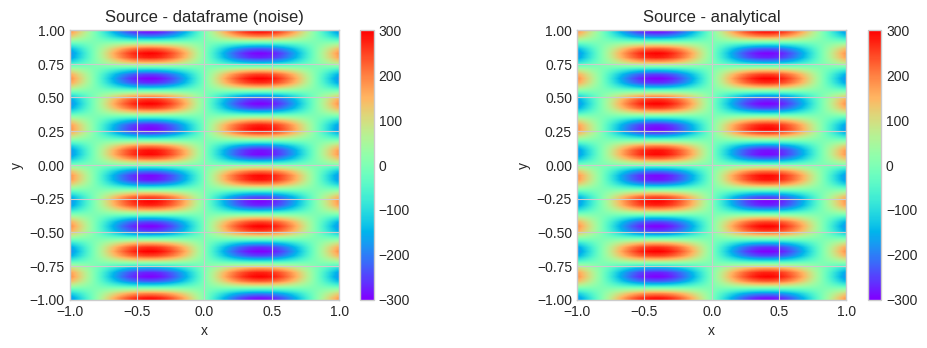

In [ ]:
#verify with a plot
print(data_analytical[:,2].shape)
fig = plt.figure(figsize=(12, 3.5))
ax1 = fig.add_subplot(1,2,1)
u_plot = data_analytical[:,2].reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - dataframe (noise)', fontsize='large');

print(g.shape) #just want to verify this.
ax1 = fig.add_subplot(1,2,2)
u_plot = g.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - analytical', fontsize='large');

In [ ]:
#Verify MSE of g and data_analytical (make sure data_analytical = g) and g shape
reshape_g = g.reshape(-1)
print(g.shape)
mse = jnp.mean(jnp.square(data_analytical[:, 2:3] - g))
rl2 = jnp.linalg.norm(g_inv - g) / jnp.linalg.norm(g)
print ('SR source mse = %.3f,  rl2 = %.3f'%(mse, rl2))

print(g.shape)
mse = jnp.mean(jnp.square(data_analytical[:,:2] - inputs))
rl2 = jnp.linalg.norm(data[:,:2] - inputs) / jnp.linalg.norm(inputs)
print ('inputs to SR MSE = %.3f,  rl2 = %.3f'%(mse, rl2))

(4096, 1)
SR source mse = 0.000,  rl2 = 90.215
(4096, 1)
inputs to SR MSE = 0.000,  rl2 = 0.000


In [ ]:
for num_iters in [300]: #, 30, 60, 80, 100
    model = PySRRegressor(
        niterations=num_iters,  # < Increase me for better results
        binary_operators=["+", "*", "-", "/"],
        unary_operators=[
            "sign",
            "neg",
            "cos",
            "exp",
            "sin",  # Pre-defined library of operators (see docs)
            "inv(x) = 1/x",  # Define your own operator! (Julia syntax)
        ],
        extra_sympy_mappings={"inv": lambda x: 1 / x},
        # ^ Define operator for SymPy as well
        elementwise_loss="loss(prediction, target) = (prediction - target)^2",
        # ^ Custom loss function (julia syntax)
    )

    print(model.fit(data_analytical[:,:2], data_analytical[:,2:3])) #fit to inputs, g
    print(model.sympy())

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.430e+04
Head worker occupation: 17.2%
Progress: 30 / 4500 total iterations (0.667%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           1.969e+04  7.971e+00  y = sin(-0.00064246)
4           1.959e+04  2.499e-03  y = neg(x₀ / x₁)
5           1.941e+04  9.356e-03  y = neg(sign(x₀) / x₁)
6           1.941e+04  5.960e-08  y = 0.051348 - (sign(x₀) / x₁)
7           1.936e+04  2.381e-03  y = neg(sign(x₀) / sin(inv(x₁)))
9           1.922e+04  3.778e-03  y = neg(sign(x₀) / (sin(inv(x₁)) * 0.65475))
13          1.913e+04  1.099e-03  y = (sign(x₀) / sin(inv(neg(x₁)))) * (cos(x₁) + cos(0.51067))
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.080e+04
Head worker occupation: 13.2%
Progress: 45 / 4500 total 

Plotting Result Functions

Inverse SR

In [52]:
def eval_sr_inv(x0, x1):
    #inverse - 600 iters
    u = jnp.sin(x1/0.058981415)*jnp.sin(x0/0.26562163)/((-0.006836929)*0.48905975)

    #inverse - 300 iters
    #u = jnp.exp(jnp.cos(x0) - 1*(-3.2063296))/jnp.sign(x0/(x1 + jnp.sin(0.0015422002 - 1.02891163496981/x1)))

    return u

In [53]:
# sample (64x64)
xs = jnp.linspace(-1, 1, 64)
ys = jnp.linspace(-1, 1, 64)
x, y = jnp.meshgrid(xs, ys)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
inputs = jnp.hstack([x, y])

soln = eval_sr_inv(x, y) #inputs from earlier, should yield shape of (4096, 1)
soln.shape, soln

((4096, 1),
 Array([[-165.44417217],
        [-136.81662434],
        [-106.23710323],
        ...,
        [-106.23710323],
        [-136.81662434],
        [-165.44417217]], dtype=float64))

(4096,)


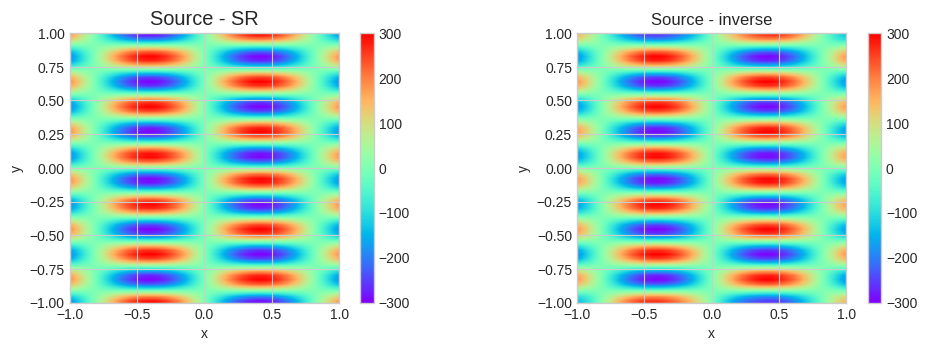

<Figure size 800x400 with 0 Axes>

In [63]:
fig = plt.figure(figsize=(12, 3.5))
ax1 = fig.add_subplot(1,2,1)
ext = [x_l, x_u, y_l, y_u]     # plot boundary
u_plot = soln.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y');
plt.title('Source - SR', fontsize='x-large');

print(g_inv.shape)
ax1 = fig.add_subplot(1,2,2)
u_plot = g_inv.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - inverse', fontsize='large');

# plot
fig = plt.figure(figsize=(8, 4))


In [55]:
#MSE between inv SR and analytical
mse = jnp.mean(jnp.square(soln - g))
rl2 = jnp.linalg.norm(soln - g) / jnp.linalg.norm(g)
print ('SR source mse = %.3f,  rl2 = %.3f'%(mse, rl2))

SR source mse = 1.857,  rl2 = 0.010


In [56]:
reshape_soln = soln.reshape(-1)

In [57]:
#MSE between inv SR and inv
mse = jnp.mean(jnp.square(reshape_soln - g_inv))
rl2 = jnp.linalg.norm(soln - g_inv) / jnp.linalg.norm(g_inv)
print ('SR source mse = %.3f,  rl2 = %.3f'%(mse, rl2)) #the mse = 13.160 doesn't seem quite right

SR source mse = 13.160,  rl2 = 90.502


Analytical SR

In [58]:
def eval_sr_analytical(x0, x1):
    #analytic - 600 iters
    u = jnp.sin(x1/0.058947027)/(0.73235995*((-0.0045363843/jnp.sin(x0/0.26532415))))

    return u

In [59]:
# sample (64x64)
xs = jnp.linspace(-1, 1, 64)
ys = jnp.linspace(-1, 1, 64)
x, y = jnp.meshgrid(xs, ys)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
inputs = jnp.hstack([x, y])

soln = eval_sr_analytical(x, y) #inputs from earlier, should yield shape of (4096, 1)
soln.shape, soln

((4096, 1),
 Array([[-168.03497458],
        [-139.17245968],
        [-108.31991098],
        ...,
        [-108.31991098],
        [-139.17245968],
        [-168.03497458]], dtype=float64))

(4096, 1)


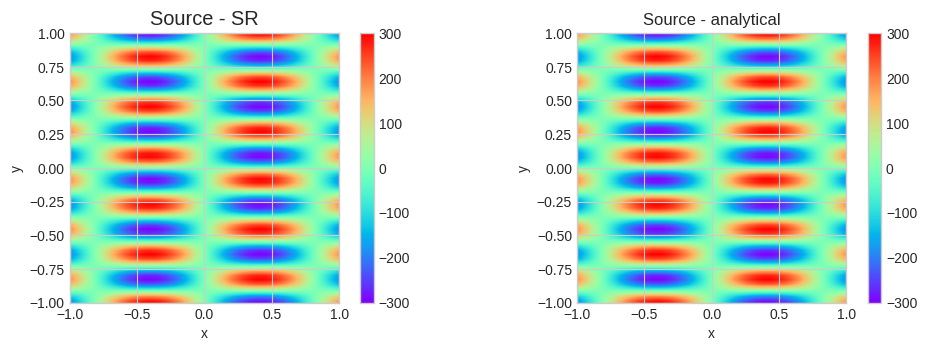

<Figure size 800x400 with 0 Axes>

In [60]:
fig = plt.figure(figsize=(12, 3.5))
ax1 = fig.add_subplot(1,2,1)
ext = [x_l, x_u, y_l, y_u]     # plot boundary
u_plot = soln.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y');
plt.title('Source - SR', fontsize='x-large');

print(g.shape)
ax1 = fig.add_subplot(1,2,2)
u_plot = g.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - analytical', fontsize='large');

# plot
fig = plt.figure(figsize=(8, 4))

In [61]:
#MSE between analytical SR and analytical
mse = jnp.mean(jnp.square(soln - g))
rl2 = jnp.linalg.norm(soln - g) / jnp.linalg.norm(g)
print ('SR source mse = %.3f,  rl2 = %.3f'%(mse, rl2))

SR source mse = 0.010,  rl2 = 0.001


In [62]:
#MSE between analytical SR and inv
mse = jnp.mean(jnp.square(reshape_soln - g_inv))
rl2 = jnp.linalg.norm(soln - g_inv) / jnp.linalg.norm(g_inv)
print ('SR source mse = %.3f,  rl2 = %.3f'%(mse, rl2))

SR source mse = 13.160,  rl2 = 90.806
